In [97]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [98]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_06 import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

In [99]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid,y_valid)

nh,bs = 50,512
c= y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds,bs), c)

In [101]:
class AvgStats():
  def __init__(self, metrics, in_train):
    self.metrics = listify(metrics)
    self.in_train = in_train
    self.tot_loss = 0.
    self.count=0
    self.tot_mets = [0.] * len(self.metrics)

  def reset(self):
    self.tot_loss, self.count = 0.,0
    self.tot_mets = [0.] * len(self.metrics)
  
  @property
  def all_stats(self): return[self.tot_loss.item()] + self.tot_mets
  @property
  def avg_stats(self): return[o/self.count for o in self.all_stats]

  def __repr__(self):
    if not self.count: return ''
    return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

  def accumulate(self, run):
    bn = run.xb.shape[0]
    self.tot_loss += run.loss * bn
    self.count += bn
    for i,m in enumerate(self.metrics):
      self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
  def __init__(self, metrics):
    self.train_stats,self.valid_stats = AvgStats(metrics,True), AvgStats(metrics, False)

  def begin_epoch(self):
    self.train_stats.reset()
    self.valid_stats.reset()

  def after_loss(self):
    stats = self.train_stats if self.in_train else self.valid_stats
    with torch.no_grad(): stats.accumulate(self.run)

  def after_epoch(self):
    print(self.train_stats)
    print(self.valid_stats)

class Recorder(Callback):
  def begin_fit(self): self.lrs, self.losses = [],[]

  def after_batch(self):
    if not self.in_train: return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

In [102]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback,mnist_view)]

In [103]:
nfs = [8,16,32,64,64]

In [104]:

#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/06_cuda_cnn_hooks_init.ipynb
#import os
#os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
#from nb_05b import *
#os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

def normalize_to(train, valid):
  m, s = train.mean(), train.std()
  return normalize(train, m, s), normalize(valid, m, s)

class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x): return self.func(x)

def flatten(x): return x.view(x.shape[0], -1)

class CudaCallback(Callback):
  def begin_fit(self): self.model.cuda()
  def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

class BatchTransformXCallback(Callback):
  _order=2
  def __init__(self, tfm): self.tfm = tfm

  def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
  def _inner(x): return x.view(*((-1,)+size))
  return _inner

def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
  if opt_func is None: opt_func = optim.SGD
  opt = opt_func(model.parameters(), lr = lr)
  learn = Learner(model, opt, loss_func, data)
  return learn, Runner(cb_funcs=listify(cbs))

class ListContainer():
  def __init__(self, items): self.items= listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx)==len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return[self.items[i] for i in idx]
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i ,o):self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
    if len(self)>10: res = res[:-1]+ ', ...]'
    return res


from torch.nn import init

class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x): return self.func(x)

def flatten(x): return x.view(x.shape[0], -1)

class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

def get_cnn_layers(data, nfs, layer, **kwargs):
  nfs = [1] + nfs
  return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
          for i in range(len(nfs)-1)] + [
  nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
  return nn.Sequential(
      nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x):
    x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x

def init_cnn(m, uniform=False):
  f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
  for l in m:
    if isinstance(l, nn.Sequential):
      f(l[0].weight, a=0.1)
      l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data, nfs,layer,**kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None,opt_func=None, uniform=False, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model, uniform=uniform)
  return get_runner(model, data,lr=lr,cbs=cbs, opt_func=opt_func)

In [105]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [106]:
%time run.fit(2,learn)

train: [1.29025953125, tensor(0.5689, device='cuda:0')]
valid: [0.3683547119140625, tensor(0.8863, device='cuda:0')]
train: [1.29025953125, tensor(0.5689, device='cuda:0')]
valid: [0.38959497767857143, tensor(0.8783, device='cuda:0')]
CPU times: user 1.3 s, sys: 239 ms, total: 1.54 s
Wall time: 1.54 s


**BatchNorm**

In [107]:
class BatchNorm(nn.Module):
  def __init__(self, nf, mom=0.1, eps=1e-5):
    super().__init__()
    self.mom, self.eps = mom, eps
    self.mults = nn.Parameter(torch.ones(nf,1,1))
    self.adds = nn.Parameter(torch.zeros(nf,1,1))
    self.register_buffer("vars", torch.ones(1,nf,1,1))
    self.register_buffer("means", torch.zeros(1,nf,1,1))

  def update_stats(self, x):
    m = x.mean((0,2,3), keepdim=True)
    v = x.var((0,2,3), keepdim=True)
    self.means.lerp_(m, self.mom)
    self.vars.lerp_(v, self.mom)
    return m,v
  
  def forward(self, x):
    if self.training:
      with torch.no_grad(): m,v = self. update_stats(x)
    else: m,v = self.means, self.vars
    x= (x-m)/ (v+self.eps).sqrt()
    return x*self.mults + self.adds

In [108]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  layers = [nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride, bias=not bn),
            GeneralRelu(**kwargs)]
  if bn: layers.append(BatchNorm(nf))
  return nn.Sequential(*layers)

In [109]:
#export
def init_cnn_(m,f):
  if isinstance(m, nn.Conv2d):
    f(m.weight, a=0.1)
    if getattr(m, 'bias',None) is not None: m.bias.data.zero_()
  for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
  f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
  init_cnn_(m,f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model, uniform=uniform)
  return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

def append_stats(i, mod, inp, outp):
  act_means[i].append(outp.data.mean())
  act_stds [i].append(outp.data.std())

def children(m): return list(m.children())

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def remove(self): self.hook.remove()
  def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[])
  means, stds = hook.stats
  means.append(outp.data.mean())
  stds.append(outp.data.std())

class ParamScheduler(Callback):
  _order = 1
  def __init__(self, pname, sched_func): 
    self.pname, self.sched_func = pname, sched_func

  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)

  def begin_batch(self):
    if self.in_train: self.set_param()

In [110]:
learn,run = get_learn_run(nfs,data,1.,conv_layer, cbs=cbfs)

train: [0.24876044921875, tensor(0.9220, device='cuda:0')]
valid: [0.14141103515625, tensor(0.9580, device='cuda:0')]


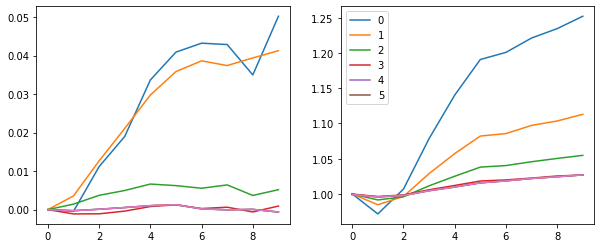

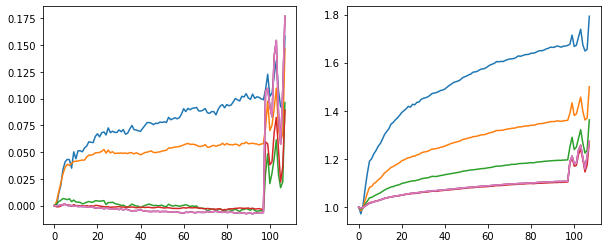

In [111]:
with Hooks(learn.model, append_stats) as hooks:
  run.fit(1, learn)
  fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks[:-1]:
    ms,ss = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
    h.remove()
  plt.legend(range(6))

  fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks[:-1]:
    ms,ss = h.stats
    ax0.plot(ms)
    ax1.plot(ss)

In [112]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [113]:
%time run.fit(3,learn)

train: [0.24924490234375, tensor(0.9218, device='cuda:0')]
valid: [0.1786708251953125, tensor(0.9414, device='cuda:0')]
train: [0.24924490234375, tensor(0.9218, device='cuda:0')]
valid: [0.18139680524553572, tensor(0.9391, device='cuda:0')]
train: [0.24924490234375, tensor(0.9218, device='cuda:0')]
valid: [0.18160646033653846, tensor(0.9390, device='cuda:0')]
CPU times: user 1.93 s, sys: 134 ms, total: 2.07 s
Wall time: 2.07 s


In [114]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  layers = [nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride,bias=not bn), 
            GeneralRelu(**kwargs)]
  if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
  return nn.Sequential(*layers)

In [115]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [116]:
%time run.fit(3, learn)

train: [0.22512095703125, tensor(0.9297, device='cuda:0')]
valid: [0.13427769775390624, tensor(0.9590, device='cuda:0')]
train: [0.22512095703125, tensor(0.9297, device='cuda:0')]
valid: [0.1266126953125, tensor(0.9601, device='cuda:0')]
train: [0.22512095703125, tensor(0.9297, device='cuda:0')]
valid: [0.12602311448317308, tensor(0.9602, device='cuda:0')]
CPU times: user 1.66 s, sys: 145 ms, total: 1.81 s
Wall time: 1.81 s


**builtin batchnorm**

In [117]:
sched = combine_scheds([0.3,0.7], [sched_lin(0.6,2.), sched_lin(2.,0.1)])

In [118]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                           +[partial(ParamScheduler, 'lr', sched)])

In [119]:
run.fit(8,learn)

train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.1489989501953125, tensor(0.9491, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.15192880859375, tensor(0.9484, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.15215417668269232, tensor(0.9483, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.15223725328947368, tensor(0.9483, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.152280390625, tensor(0.9483, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.15230684223790322, tensor(0.9483, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.15232474662162163, tensor(0.9483, device='cuda:0')]
train: [0.24323345703125, tensor(0.9280, device='cuda:0')]
valid: [0.1523376816860465, tensor(0.9483, device='cuda:0')]


**More Norms**

Look into lesson 10 1.45.00-1.50.00

In [124]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [125]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias= not bn),
            GeneralRelu(**kwargs)]
  if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
  return nn.Sequential(*layers)

In [126]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [127]:
%time run.fit(1, learn)

train: [2.36340625, tensor(0.1570, device='cuda:0')]
valid: [5474.9436, tensor(0.1099, device='cuda:0')]
CPU times: user 1min 4s, sys: 1.42 s, total: 1min 6s
Wall time: 1min 6s


**Runnig Batch Norm**

In [152]:
class RunningBatchNorm(nn.Module):
  def __init__(self, nf, mom=0.1, eps=1e-5):
    super().__init__()
    self.mom,self.eps = mom,eps
    self.mults = nn.Parameter(torch.ones(nf,1,1))
    self.adds = nn.Parameter(torch.zeros(nf,1,1))
    self.register_buffer('sums', torch.zeros(1, nf,1,1))
    self.register_buffer('sqrs', torch.zeros(1, nf,1,1))
    self.register_buffer('batch', tensor(0.))
    self.register_buffer('count', tensor(0.))
    self.register_buffer('step', tensor(0.))
    self.register_buffer('dbias', tensor(0.))

  def update_stats(self, x):
    bs,nc,*_ = x.shape
    self.sums.detach_()
    self.sqrs.detach_()
    dims = (0,2,3)
    s = x.sum(dims, keepdim=True)
    ss = (x*x).sum(dims, keepdim=True)
    c = self.count.new_tensor(x.numel()/nc)
    self.mom1 = self.dbias.new_tensor(1-(1-self.mom)**bs)
    self.sums.lerp_(s, self.mom1)
    self.sqrs.lerp_(ss, self.mom1)
    self.count.lerp_(c, self.mom1)
    self.dbias.lerp_(self.mom1, self.mom1)
    self.batch += bs
    self.step += 1

  def forward(self, x):
    if self.training: self.update_stats(x)
    sums = self.sums
    sqrs = self.sqrs
    c = self.count
    if self.step <100:
      sums = sums  / self. dbias
      sqrs = sqrs / self.dbias
      c = c       / self.dbias
    means = sums/c
    vars = (sqrs/c).sub_(means*means)
    if bool(self.batch < 20): vars.clamp_min_(0.1)
    x = (x-means).div_((vars.add_(self.eps)).sqrt())
    return x.mul_(self.mults).add_(self.adds)

In [153]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = not bn),
            GeneralRelu(**kwargs)]
  if bn: layers.append(RunningBatchNorm(nf))
  return nn.Sequential(*layers)

In [154]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [155]:
%time run.fit(1, learn)

train: [0.4555563671875, tensor(0.8811, device='cuda:0')]
valid: [8.48281328125, tensor(0.9486, device='cuda:0')]
CPU times: user 2min 28s, sys: 2.53 s, total: 2min 30s
Wall time: 2min 31s
